# Import 

In [1]:
# STANDARD PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from datetime import datetime as dt
import time
import json
import random
from tqdm import tqdm #https://pypi.org/project/tqdm/#ipython-jupyter-integ½ration
from functools import reduce
import pickle
import itertools
import warnings
import platform
import multiprocessing as mp

from xgboost import XGBRegressor
import xgboost as xgb

# SCRAPE PACKAGES
import requests
from bs4 import BeautifulSoup
# from pytrends.request import TrendReq #pip install pytrends

# MODEL PACKAGES
    #SKLEARN
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from statsmodels.tsa.x13 import x13_arima_analysis as x13



# CUSTOM FUNCTIONS

import os
import sys
currentdir = os.path.dirname(os.path.realpath('analysis_DK'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from func import (chunks, reindex, global_id, term_list, time_corr_plot, rmse, time_variable_plot, find_highest_corr, test_train_split, test_train_split_Q,
                  bootstrap_all_windows, bootstrap_n_samples, bootstrap_sample, final_model, final_model_boot, ar_1, grid_bestpar, tuning_window, tuning_window_mp, tuning_window_bestpar,
                  model_tuning, seasadj, seasadj_col_list, abs_percentage_change, add_poly_terms, create_interaction, GT_dict)

## Bootstrap

### Baseline -  AR(2) with y_t-1 + y_t-12

#### Subset data 

In [2]:
df_analysis = pd.read_csv('data/descriptive/df_descriptive.csv', parse_dates=['date'])

In [3]:
df_analysis = df_analysis[df_analysis.country == 'SE']

In [4]:
df_analysis = df_analysis[~(df_analysis.ID == 'Jämtland')]

In [5]:
df_analysis = df_analysis.drop(['GT_NO_0', 'GT_NO_1', 'GT_NO_2', 'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10', 'GT_NO_11',  
                                'GT_DK_0', 'GT_DK_1','GT_DK_2', 'GT_DK_3', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8',
                                'GT_DK_9', 'GT_DK_10', 'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14',
                                'GT_DK_15', 'GT_DK_16', 'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21',
                                'country'], axis = 1)

#### Preprocessing

#### Transform relevant columns to abs change exept those with M_ and ID_, date and t

In [6]:
df_analysis['target_actual'] = df_analysis.groupby(['ID'])['target_actual'].diff()

#### Lagged variables

In [7]:
df_analysis['target_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(1)

In [8]:
df_analysis['target_4_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(4)

#### Creating dummies from categorial variables - remember to drop the reference category (done after change is constructed)

In [9]:
df_analysis = pd.get_dummies(df_analysis, prefix=['ID'], prefix_sep='_', columns=['ID']).copy()

#### Adding interaction terms by regions and all variables

In [10]:
# relevant interaction variables
interaction_1 = ['target_lag', 'target_4_lag'] 

interaction_2 = [item for item in df_analysis if item.startswith('ID_')]

In [11]:
for var1 in interaction_1:
    for var2 in interaction_2:
        name = var1 + "*" + var2
        df_analysis[name] = pd.Series(df_analysis[var1] * df_analysis[var2], name=name)

#### Drop na

In [12]:
df_analysis.dropna(inplace=True)

In [13]:
df_analysis.sort_index(axis=1, inplace=True)

In [14]:
window = 11
testsize = 1
valsize = 1
rolling_window = True
params = []
n_components = []

In [15]:
df_analysis.columns

Index(['GT_SE_0', 'GT_SE_1', 'GT_SE_10', 'GT_SE_11', 'GT_SE_2', 'GT_SE_5',
       'GT_SE_6', 'GT_SE_7', 'GT_SE_8', 'GT_SE_9', 'ID_Blekinge', 'ID_Dalarna',
       'ID_Gotland', 'ID_Gävleborg', 'ID_Halland', 'ID_Jönköping', 'ID_Kalmar',
       'ID_Kronoberg', 'ID_Norrbotten', 'ID_Skåne', 'ID_Stockholm',
       'ID_Södermanland', 'ID_Uppsala', 'ID_Värmland', 'ID_Västerbotten',
       'ID_Västernorrland', 'ID_Västmanland', 'ID_Västra Götalands',
       'ID_Örebro', 'ID_Östergötland', 'date', 'high_edu_share', 'jobs',
       'labour_force_share', 'population', 'sector_engineering_technology',
       'sector_industry_craft', 'sector_information_technology',
       'sector_management_staff', 'sector_office_finance', 'sector_other',
       'sector_sales_communication', 'sector_social_health', 'sector_teaching',
       'sector_trade_service', 'target_4_lag', 'target_4_lag*ID_Blekinge',
       'target_4_lag*ID_Dalarna', 'target_4_lag*ID_Gotland',
       'target_4_lag*ID_Gävleborg', 'target_4_lag

#### Select relevant columns

In [16]:
df_ar = df_analysis[['date', 'target_actual', 
                     'target_lag*ID_Blekinge', 'target_lag*ID_Dalarna', 'target_lag*ID_Gotland', 'target_lag*ID_Gävleborg', 
                     'target_lag*ID_Halland', 'target_lag*ID_Jönköping', 'target_lag*ID_Kalmar', 
                     'target_lag*ID_Kronoberg', 'target_lag*ID_Norrbotten', 'target_lag*ID_Skåne', 'target_lag*ID_Stockholm', 
                     'target_lag*ID_Södermanland', 'target_lag*ID_Uppsala', 'target_lag*ID_Värmland', 'target_lag*ID_Västerbotten', 
                     'target_lag*ID_Västernorrland', 'target_lag*ID_Västmanland', 'target_lag*ID_Västra Götalands', 'target_lag*ID_Örebro', 
                     'target_lag*ID_Östergötland',
                    'target_4_lag*ID_Blekinge', 'target_4_lag*ID_Dalarna', 'target_4_lag*ID_Gotland',
                     'target_4_lag*ID_Gävleborg', 'target_4_lag*ID_Halland', 'target_4_lag*ID_Jönköping', 
                     'target_4_lag*ID_Kalmar', 'target_4_lag*ID_Kronoberg', 'target_4_lag*ID_Norrbotten', 'target_4_lag*ID_Skåne', 
                     'target_4_lag*ID_Stockholm', 'target_4_lag*ID_Södermanland', 'target_4_lag*ID_Uppsala', 'target_4_lag*ID_Värmland',
                     'target_4_lag*ID_Västerbotten', 'target_4_lag*ID_Västernorrland', 'target_4_lag*ID_Västmanland', 
                     'target_4_lag*ID_Västra Götalands', 'target_4_lag*ID_Örebro', 'target_4_lag*ID_Östergötland',
                    'ID_Blekinge', 'ID_Dalarna',
       'ID_Gotland', 'ID_Gävleborg', 'ID_Halland', 'ID_Jönköping', 'ID_Kalmar',
       'ID_Kronoberg', 'ID_Norrbotten', 'ID_Skåne', 'ID_Stockholm',
       'ID_Södermanland', 'ID_Uppsala', 'ID_Värmland', 'ID_Västerbotten',
       'ID_Västernorrland', 'ID_Västmanland', 'ID_Västra Götalands',
       'ID_Örebro', 'ID_Östergötland']]

In [17]:
df_ar = df_ar.drop(['ID_Blekinge'], axis = 1)

#### To Quarter data

In [18]:
df_ar['date'] = df_ar.set_index('date').index.to_period('Q')

In [19]:
df_ar['date'].min()

Period('2008Q2', 'Q-DEC')

In [20]:
df_ar['date'].max()

Period('2019Q3', 'Q-DEC')

#### Subset for period to match DK

In [21]:
df_ar = df_ar[df_ar.date >= '01-01-2008']

#### Running baseline model

In [22]:
X_train_ar, X_val_ar, X_test_ar, y_train_ar, y_val_ar, y_test_ar, y_dates_ar = test_train_split_Q(df = df_ar, window = window, testsize=testsize, valsize = valsize,
                                                                  y_col='target_actual', rolling_window = rolling_window, df_output= True, geo_count = 20)

#### Concatting val and train

In [23]:
for win in X_train_ar.keys():
    X_train_ar[win] = pd.concat((X_train_ar[win], X_val_ar[win])).copy()
    y_train_ar[win] = pd.concat((y_train_ar[win], y_val_ar[win])).copy()

## ML - Data and preprocessing 

### Import data frame with adjusted here

### Subset data 

In [24]:
df_analysis = pd.read_csv('data/descriptive/df_descriptive.csv', parse_dates=['date'])

In [25]:
df_analysis = df_analysis[df_analysis.country == 'SE']

In [26]:
df_analysis = df_analysis[~(df_analysis.ID == 'Jämtland')]

In [27]:
df_analysis = df_analysis.drop(['GT_NO_0', 'GT_NO_1', 'GT_NO_2', 'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10', 'GT_NO_11',  
                                'GT_DK_0', 'GT_DK_1', 'GT_DK_2', 'GT_DK_3', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8',
                                'GT_DK_9', 'GT_DK_10', 'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14',
                                'GT_DK_15', 'GT_DK_16', 'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21',
                                'country'], axis = 1)

In [28]:
df_analysis.date.min()

Timestamp('2007-01-01 00:00:00')

In [29]:
df_analysis.date.max()

Timestamp('2019-07-01 00:00:00')

### Initial preprocessing and feature construction

- Create dummies 
- Create interaction terms

Overall monthly time trend variable, $t=1,2...,T$ within `ID` variable:

In [30]:
#Temp container
temp = {}

for i in df_analysis['ID'].unique():
    temp[i] = df_analysis[df_analysis['ID']==i]
    temp[i]['t'] = range(1, len(temp[i]['ID'])+1)

#Concatting the df's
temp = pd.concat(temp, ignore_index=True, sort = False)

#Merging onto analysis
df_analysis = pd.merge(left = df_analysis, right = temp[['date', 'ID', 't']], left_on =['date', 'ID'], right_on = ['date', 'ID'])

C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Drop sector variables

criteria = 0.2

In [31]:
df_analysis.drop(['sector_management_staff', 'sector_trade_service', 'sector_sales_communication', 'sector_teaching', 'sector_social_health', 'sector_other'], axis = 1, inplace=True)

#### Transform relevant columns to abs change exept those with M_ and ID_, date and t

In [32]:
df_analysis['target_actual'] = df_analysis.groupby(['ID'])['target_actual'].diff()

### Lagged variables

In [33]:
df_analysis['target_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(1)

NB! As this is Quarterly data one year lag is 4 quarters

In [34]:
df_analysis['target_4_lag'] = df_analysis.groupby(['ID'])['target_actual'].shift(4)

#### Create new variables with 3 month (1 quarter) lag of jobrate

In [35]:
columns_1q_lag = ['jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_industry_craft','sector_office_finance']

for colname in columns_1q_lag:
    df_analysis[str(colname + '_1_lag')] = df_analysis.groupby(['ID'])[colname].shift(1)

#### Dropping some GT variables

In [36]:
# Dropping some GT's
drop_list = ['GT_SE_6', 'GT_SE_8', 'GT_SE_10', 'GT_SE_11']

In [37]:
df_analysis.drop(drop_list, axis = 1, inplace=True)

#### Create new variables with 1 month lag of GT

In [38]:
columns_1q_lag = [ 'GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_7', 'GT_SE_9']
for colname in columns_1q_lag:
    df_analysis[str(colname + '_1_lag')] = df_analysis.groupby(['ID'])[colname].shift(1)

#### Month dummies for season effects

In [39]:
df_analysis['quarter'] = pd.DatetimeIndex(df_analysis['date']).month.astype(str)

#### Creating dummies from categorial variables - remember to drop the reference category (done after change is constructed)

In [40]:
list_id = df_analysis.ID.value_counts().index.to_list()

In [41]:
df_analysis = pd.get_dummies(df_analysis, prefix=['ID','Q'], prefix_sep='_', columns=['ID', 'quarter']).copy()

#### Drop na

In [42]:
df_analysis.dropna(inplace=True)

In [43]:
df_analysis.date.max()

Timestamp('2019-07-01 00:00:00')

In [44]:
df_analysis.date.min()

Timestamp('2008-04-01 00:00:00')

#### Adding interaction terms

Polynominal features - To be deleted later

In [45]:
#df_analysis = add_poly_terms(df = df_analysis, 
#                            poly_columns = ['target_actual', 'GT_0', 'GT_1', 'GT_2', 'GT_3', 'GT_4', 'GT_5', 'GT_6', 'GT_7', 'GT_8', 'GT_9', 'GT_10', 'GT_11', 'GT_12', 'GT_13', 'GT_14', 'GT_15', 'GT_16', 'GT_17', 'GT_18', 'GT_19', 'target_lag', 'jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'])

In [46]:
#df_analysis.dropna(inplace=True)

Adding interaction terms by regions and all variables

In [47]:
# # relevant interaction variables
# interaction_1 = ['target_lag', 'target_4_lag'] 
# # 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other'

# # get list of all ID area 
# interaction_2 = [item for item in df_analysis if item.startswith('ID_')]

In [48]:
# for var1 in interaction_1:
#     for var2 in interaction_2:
#         name = var1 + "*" + var2
#         df_analysis[name] = pd.Series(df_analysis[var1] * df_analysis[var2], name=name)

#### Drop variables to not end up in dummytrap

In [49]:
df_analysis = df_analysis.drop(['ID_Blekinge', 'Q_1'], axis = 1)

In [50]:
# df_analysis.drop(interaction_1, axis = 1, inplace=True)

In [51]:
df_analysis.sort_index(axis=1, inplace=True)

#### To Quarter data

In [52]:
df_analysis['date'] = df_analysis.set_index('date').index.to_period('Q')

In [53]:
df_analysis['date'].min()

Period('2008Q2', 'Q-DEC')

In [54]:
df_analysis['date'].max()

Period('2019Q3', 'Q-DEC')

#### Subset for period to match DK

In [55]:
df_analysis = df_analysis[df_analysis.date >= '01-01-2008']

#### Setting window size

In [56]:
window = 11
testsize = 1
valsize = 1
rolling_window = True

# Bootstap

#### Load and import

In [57]:
import numpy as np, scipy.stats as st

In [58]:
# load data
with open('results/final/xgboost/results_final_noint.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)
    
with open('results/final/baseline/results_ar_year_lag.pickle', 'rb') as handle:
    results_baseline = pickle.load(handle)
    
with open('results/final/randomforest/results_final_noint.pickle', 'rb') as handle:
    results_randomforest = pickle.load(handle)    
    
with open('results/final/baseline/results_ar_year_lag.pickle', 'rb') as handle:
    results_ar = pickle.load(handle)
    
# TEST DATES FOR EACH WINDOW
with open('results/final/y_dates.pickle', 'rb') as handle:
    y_dates = pickle.load(handle)

In [59]:
df_analysis_temp = pd.read_csv('data/descriptive/df_analysis.csv', sep = ',', parse_dates = ['date'])

df_results = df_analysis_temp[['ID', 'date', 'target_actual']].copy()

df_results = df_results[~(df_results['ID'] =='Jämtland')]

#1st diff
df_results['target_diff'] = df_results.groupby('ID')['target_actual'].diff()

In [60]:
y_dates[1]['temp']=df_results['ID']

In [61]:
list_id = y_dates[1]['temp'].to_list()

In [62]:
model =  results_xgboost #results_randomforest
baseline = results_ar

#### Construct bootstrap samples

Concat X_train and x_val: X_train

In [63]:
X_train, X_val, X_test, y_train, y_val, y_test, dates = test_train_split_Q(df = df_analysis, window = window, testsize=testsize, valsize = valsize,
                                                                  y_col='target_actual', rolling_window = rolling_window, df_output= True, geo_count = 20)

 Create 1000 bootstraps in each window

In [64]:
n_samples = 5000

In [65]:
X_train_boot_sample, X_test_boot_sample, y_train_boot_sample, y_test_boot_sample = bootstrap_all_windows(X_train, X_test, y_train, y_test, sample_size = 20,
                                                                                                         n_samples = n_samples, df_output = True)


Bootstrap sampling: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:13<00:00,  2.53it/s]


In [67]:
with open('results/final/bootstrap/X_train_boot_sample.pickle', 'wb') as handle:
    pickle.dump(X_train_boot_sample, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/X_test_boot_sample.pickle', 'wb') as handle:
    pickle.dump(X_test_boot_sample, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/y_train_boot_sample.pickle', 'wb') as handle:
    pickle.dump(y_train_boot_sample, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/y_test_boot_sample.pickle', 'wb') as handle:
    pickle.dump(y_test_boot_sample, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [68]:
X_train_boot_sample_ar, X_test_boot_sample_ar, y_train_boot_sample_ar, y_test_boot_sample_ar = bootstrap_all_windows(X_train_ar, X_test_ar, y_train_ar, y_test_ar, sample_size = 20,
                                                                                                         n_samples = n_samples, df_output = True)


Bootstrap sampling: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.05it/s]


In [69]:
with open('results/final/bootstrap/X_train_boot_sample_ar.pickle', 'wb') as handle:
    pickle.dump(X_train_boot_sample_ar, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/X_test_boot_sample_ar.pickle', 'wb') as handle:
    pickle.dump(X_test_boot_sample_ar, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/y_train_boot_sample_ar.pickle', 'wb') as handle:
    pickle.dump(y_train_boot_sample_ar, handle, protocol= pickle.HIGHEST_PROTOCOL)
    
with open('results/final/bootstrap/y_test_boot_sample_ar.pickle', 'wb') as handle:
    pickle.dump(y_test_boot_sample_ar, handle, protocol= pickle.HIGHEST_PROTOCOL)

#### Results bootstrap

In [66]:
def results_bootstrap(X_train_boot_sample, X_test_boot_sample, y_train_boot_sample, y_test_boot_sample, model):
    
    drop_list = ['ID_Dalarna',
       'ID_Gotland', 'ID_Gävleborg', 'ID_Halland', 'ID_Jönköping', 'ID_Kalmar',
       'ID_Kronoberg', 'ID_Norrbotten', 'ID_Skåne', 'ID_Stockholm',
       'ID_Södermanland', 'ID_Uppsala', 'ID_Värmland', 'ID_Västerbotten',
       'ID_Västernorrland', 'ID_Västmanland', 'ID_Västra Götalands',
       'ID_Örebro', 'ID_Östergötland']
    
    
    for win in X_train_ar.keys():
        X_train_ar[win].drop(drop_list, axis = 1, inplace = True)
        X_test_ar[win].drop(drop_list, axis = 1, inplace = True)
        
        for boot in X_train_boot_sample_ar[win].keys():
            X_train_boot_sample_ar[win][boot].drop(drop_list, axis = 1, inplace = True)
            X_test_boot_sample_ar[win][boot].drop(drop_list, axis = 1, inplace = True)
    
    for win in X_train.keys():
        sc = StandardScaler()
        X_train[win] = sc.fit_transform(X_train[win])
        X_test[win] = sc.transform(X_test[win])
    
    for win in X_train_ar.keys():
        sc = StandardScaler()
        X_train_ar[win] = sc.fit_transform(X_train_ar[win])
        X_test_ar[win] = sc.transform(X_test_ar[win])
    
    #Initial dataframe
    results = {}
    
    

    for win in tqdm(X_train_boot_sample.keys()):


    # Create model for machine learning     
        #initial dictionaries
        results[win] = {}

        #CREATING MODEL OBJECT
        n_estimators = model[win]['best_rmse'][0][1]
        max_depth = model[win]['best_rmse'][0][2]
        colsample_bytree = model[win]['best_rmse'][0][3]
        gamma = model[win]['best_rmse'][0][4]
        subsample = model[win]['best_rmse'][0][5]
        min_child_weight = model[win]['best_rmse'][0][6]

        model_reg = XGBRegressor(objective ='reg:squarederror', 
                                                colsample_bytree = colsample_bytree, 
                                                learning_rate = 0.1,
                                                max_depth = max_depth,
                                                n_estimators = n_estimators,
                                                gamma = gamma,
                                                subsample = subsample,
                                                min_child_weight = min_child_weight,
                                                n_jobs = -1,
                                                seed = 1)
        
        model_reg.fit(X_train[win], y_train[win])
        
    #Create model for baseline
        
        
        model_reg_ar = LinearRegression()
        model_reg_ar.fit(X_train_ar[win], y_train_ar[win])
    
        for boot in X_train_boot_sample[win].keys():
            
            sc = StandardScaler()
            X_train_boot_sample_ar[win][boot] = sc.fit_transform(X_train_boot_sample_ar[win][boot])
            X_test_boot_sample_ar[win][boot] = sc.transform(X_test_boot_sample_ar[win][boot])
            
            sc = StandardScaler()
            X_train_boot_sample[win][boot] = sc.fit_transform(X_train_boot_sample[win][boot])
            X_test_boot_sample[win][boot] = sc.transform(X_test_boot_sample[win][boot])

            # Construct results
            results[win][boot] = {}
            
            # results model
            y_pred = model_reg.predict(X_test_boot_sample[win][boot]).round(2)
            par_rmse = rmse(y_pred.round(2), y_true= y_test_boot_sample[win][boot])
            
            # results baseline
            y_pred_ar = model_reg_ar.predict(X_test_boot_sample_ar[win][boot]).round(2)
            par_rmse_ar = rmse(y_pred_ar.round(2), y_true= y_test_boot_sample_ar[win][boot])
            
            # save results to dict
            # model
            results[win][boot]['y_pred_model'] = y_pred
            results[win][boot]['rmse_model'] =par_rmse
            results[win][boot]['y_actual_model'] = y_test_boot_sample[win][boot]  
            
            # baseline
            results[win][boot]['y_pred_ar'] = y_pred_ar
            results[win][boot]['rmse_ar'] =par_rmse_ar
            results[win][boot]['y_actual_ar'] = y_test_boot_sample_ar[win][boot] 
        
    return results

In [67]:
results = results_bootstrap(X_train_boot_sample, X_test_boot_sample, y_train_boot_sample, y_test_boot_sample, model)

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
  3%|██▍                                                                                | 1/34 [00:07<04:05,  7.45s/it]C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
  6%|████▉                                                                              | 2/34 [00:14<03:58,  7.46s/it]C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'ba

Get list with y_pred and y_actual

In [68]:
# Initiale region, bootstrap and windows
region = {}
windows = list(results.keys())
bootstraps = list(results[1].keys())


for win in windows:
    # initiate lists
    list_win_rmse = []
    list_win_y_pred = []
    list_win_y_actual_model = []
    list_win_y_actual_ar = []    
    list_win_rmse_ar = []
    list_win_y_pred_ar = []

    for boot in bootstraps:
        #retrive rmse, y_pred, and y_actual for each bootstrap in each window
        list_win_rmse.append(results[win][boot]['rmse_model'])
        list_win_y_pred.append(results[win][boot]['y_pred_model'])
        list_win_y_actual_model.append(list(results[win][boot]['y_actual_model'].round(2)))
        
              
        list_win_rmse_ar.append(results[win][boot]['rmse_ar'])
        list_win_y_pred_ar.append(results[win][boot]['y_pred_ar'])
        list_win_y_actual_ar.append(list(results[win][boot]['y_actual_ar'].round(2)))  
    
    for reg in range(0,len(list_id)): 
        #Create result df with regions 
        result_region = {}
        region_num = list_id[reg]

        result_region[region_num] = {}
        result_region[region_num]['y_pred_model'] = [boot[reg] for boot in list_win_y_pred]
        result_region[region_num]['y_actual_model'] = [boot[reg] for boot in list_win_y_actual_model]
        result_region[region_num]['y_actual_ar'] = [boot[reg] for boot in list_win_y_actual_ar]
        
        result_region[region_num]['y_pred_ar'] = [boot[reg] for boot in list_win_y_pred_ar]

        region.update(result_region)
        
        #Append to results dict    
        results[win]['bootstrap_results'] = region

        # construct conf interval
        results[win]['bootstrap_results']['rmse_model'] = list_win_rmse
        results[win]['bootstrap_results']['conf_lower_model'] = np.percentile(results[win]['bootstrap_results']['rmse_model'], 2.5)
        results[win]['bootstrap_results']['conf_upper_model'] =np.percentile(results[win]['bootstrap_results']['rmse_model'], 97.5)

        results[win]['bootstrap_results']['rmse_ar'] = list_win_rmse_ar
        results[win]['bootstrap_results']['conf_lower_ar'] = np.percentile(results[win]['bootstrap_results']['rmse_ar'], 2.5)
        results[win]['bootstrap_results']['conf_upper_ar'] = np.percentile(results[win]['bootstrap_results']['rmse_ar'], 97.5)

    

#### Save to pickle

In [69]:
with open('results/final/bootstrap/results_bootstrap.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [70]:
results[6][3]

{'y_pred_model': array([-2.04, -0.97, -0.73, -0.97, -0.78, -0.7 , -0.97, -2.04, -1.34,
        -1.57, -1.81, -1.81, -0.73, -0.16, -1.57, -1.1 , -2.06, -1.08,
        -0.78, -1.81], dtype=float32),
 'rmse_model': 0.8575022021708844,
 'y_actual_model': index
 226   -2.12
 175   -0.41
 481   -0.23
 175   -0.41
 889   -1.46
 532   -0.55
 175   -0.41
 226   -2.12
 124   -1.90
 379    0.15
 787   -2.06
 787   -2.06
 481   -0.23
 22    -0.61
 379    0.15
 583    0.37
 685   -0.24
 634   -0.62
 889   -1.46
 787   -2.06
 Name: target_actual, dtype: float64,
 'y_pred_ar': array([-0.02, -1.07, -0.06, -0.44, -1.07, -0.56,  0.06, -0.51, -0.9 ,
        -0.9 , -2.29, -0.72, -0.56, -0.51, -0.56, -0.71, -0.51, -0.51,
        -0.44, -0.06]),
 'rmse_ar': 1.033706921714274,
 'y_actual_ar': index
 634     0.37
 838    -2.06
 328    -0.82
 1042   -2.61
 838    -2.06
 940    -1.46
 22     -0.61
 583    -0.55
 889    -2.55
 889    -2.55
 226    -2.12
 175    -0.41
 940    -1.46
 583    -0.55
 940    -1.46
 53

In [71]:
results[1]['bootstrap_results']['Stockholm']['y_pred_model']

[-0.99,
 0.34,
 -1.35,
 -1.22,
 0.48,
 -0.29,
 -0.15,
 0.08,
 0.01,
 -0.01,
 0.1,
 -0.41,
 -0.56,
 0.54,
 0.09,
 -0.74,
 -1.41,
 -0.44,
 -0.14,
 -0.14,
 0.09,
 -0.32,
 -0.35,
 -0.37,
 -0.69,
 -0.32,
 -0.87,
 -1.55,
 -0.27,
 -0.75,
 -0.28,
 -0.85,
 -0.71,
 -0.42,
 0.44,
 -0.34,
 -0.96,
 -0.44,
 -0.66,
 -0.35,
 -0.56,
 -0.32,
 0.47,
 -1.57,
 0.57,
 -0.09,
 -0.0,
 0.03,
 -0.53,
 0.0,
 0.11,
 -0.42,
 -1.04,
 -0.64,
 -0.5,
 -1.33,
 -0.66,
 -0.45,
 -1.13,
 -0.76,
 -0.21,
 0.17,
 -0.49,
 -1.54,
 -0.22,
 -0.86,
 -0.89,
 -0.31,
 -1.18,
 -1.09,
 -0.31,
 0.18,
 -0.58,
 -0.68,
 -0.25,
 -1.31,
 0.22,
 -1.01,
 -0.57,
 -0.13,
 -0.99,
 0.19,
 -1.1,
 0.34,
 -0.48,
 0.06,
 0.16,
 -0.32,
 -1.21,
 -0.03,
 -0.83,
 -0.73,
 -0.34,
 0.06,
 -0.47,
 -0.75,
 0.04,
 -0.37,
 -0.55,
 -0.47,
 -1.03,
 0.29,
 0.41,
 0.3,
 -0.91,
 -0.83,
 0.39,
 0.27,
 0.02,
 -0.55,
 0.13,
 0.42,
 -1.42,
 -0.65,
 0.6,
 -0.26,
 -0.17,
 -0.7,
 -0.57,
 -0.36,
 0.4,
 -1.29,
 -0.67,
 0.48,
 0.26,
 0.11,
 -0.88,
 0.32,
 -1.62,
 0.2,
 0.11,
 

#### Check the results

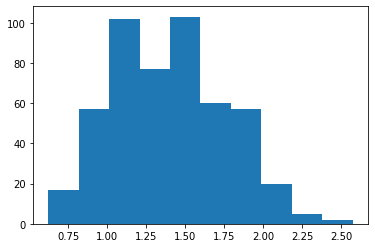

In [72]:
plt.hist(results[1]['bootstrap_results']['rmse_model'])
plt.show()

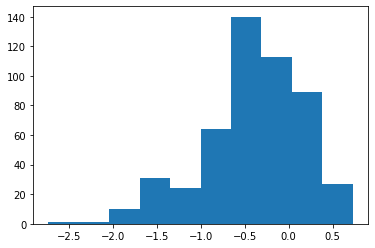

In [73]:
plt.hist(results[1]['bootstrap_results']['Stockholm']['y_pred_model'])
plt.show()

In [74]:
results[1]['bootstrap_results'].keys()

dict_keys(['Blekinge', 'rmse_model', 'conf_lower_model', 'conf_upper_model', 'rmse_ar', 'conf_lower_ar', 'conf_upper_ar', 'Dalarna', 'Gotland', 'Gävleborg', 'Halland', 'Jönköping', 'Kalmar', 'Kronoberg', 'Norrbotten', 'Skåne', 'Stockholm', 'Södermanland', 'Uppsala', 'Värmland', 'Västerbotten', 'Västernorrland', 'Västmanland', 'Västra Götalands', 'Örebro', 'Östergötland'])

In [75]:
results[1]['bootstrap_results']['conf_lower_model']

0.8016579066512118

In [ ]:
results[1]['bootstrap_results']['conf_lower_ar']

In [ ]:
results[1]['bootstrap_results']['conf_upper_ar']

In [ ]:
results[1]['bootstrap_results']['conf_lower_model']

In [ ]:
results[1]['bootstrap_results']['conf_upper_model']

#### Function for XGBoost 

In [ ]:
# def results_bootstrap(X_train_boot_sample, X_test_boot_sample, y_train_boot_sample, y_test_boot_sample, model):
    
#     #Initial dataframe
#     results = {}

#     for win in tqdm(X_train_boot_sample.keys()):

#     # Create model for machine learning     
#         #initial dictionaries
#         results[win] = {}

#         #CREATING MODEL OBJECT
#         n_estimators = model[win]['best_rmse'][0][1]
#         max_depth = model[win]['best_rmse'][0][2]
#         colsample_bytree = model[win]['best_rmse'][0][3]
#         gamma = model[win]['best_rmse'][0][4]
#         subsample = model[win]['best_rmse'][0][5]
#         min_child_weight = model[win]['best_rmse'][0][6]

#         model = XGBRegressor(objective ='reg:squarederror', 
#                                                 colsample_bytree = colsample_bytree, 
#                                                 learning_rate = 0.1,
#                                                 max_depth = max_depth,
#                                                 n_estimators = n_estimators,
#                                                 gamma = gamma,
#                                                 subsample = subsample,
#                                                 min_child_weight = min_child_weight,
#                                                 n_jobs = -1,
#                                                 seed = 1)
        
#     #Create model for baseline 
#         model_reg_ar = LinearRegression()
#         model_reg_ar.fit(X_train[win], y_train[win])
    
#         for boot in X_train_boot_sample[win].keys():

#             # Construct results
#             results[win][boot] = {}
            
#             # results model
#             y_pred = model_reg.predict(X_test_boot_sample[win][boot]).round(2)
#             par_rmse = rmse(y_pred.round(2), y_true= y_test_boot_sample[win][boot])
            
#             # results baseline
#             y_pred_ar = model_reg_ar.predict(X_test_boot_sample[win][boot]).round(2)
#             par_rmse_ar = rmse(y_pred_ar.round(2), y_true= y_test_boot_sample[win][boot])
            
#             # save results to dict
#             # model
#             results[win][boot]['y_pred_model'] = y_pred
#             results[win][boot]['rmse_model'] =par_rmse
#             results[win][boot]['y_actual'] = y_test_boot_sample[win][boot]  
            
#             # baseline
#             results[win][boot]['y_pred_ar'] = y_pred_ar
#             results[win][boot]['rmse_ar'] =par_rmse_ar
        
#     return results